# Recurrent Neural Network

I modified the code that is brought from the following reference: https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/402_RNN_classifier.py

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_class = 10
n_epoch = 5
time_step = 28          # rnn time step / image height
input_size = 28         # rnn input size / image width
batch_size = 256
test_batch_size = 1000
lr = 1e-3
device = 0

In [3]:
train_data = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)

In [5]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])         # out shape (batch_size, class_num)
        return out, r_out[:, -1, :]

    def classify(self, img):
        logit, x = self(img)
        return self.classify_from_logit(logit), x

    def classify_from_logit(self, logit):
        return logit.argmax(dim=-1)

In [6]:
classifier = RNN().to(device)
print(classifier)  # net architecture

optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()                       

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

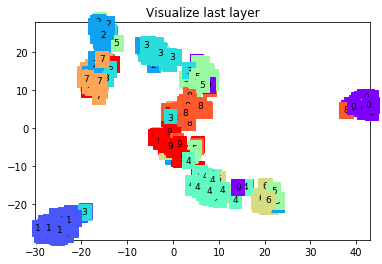

Train-Acc@0: 0.6249
Test-Acc@0: 0.8731


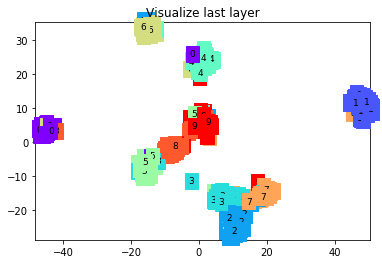

Train-Acc@1: 0.9120166666666667
Test-Acc@1: 0.9254


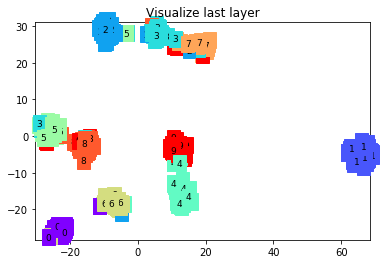

Train-Acc@2: 0.9394
Test-Acc@2: 0.9486


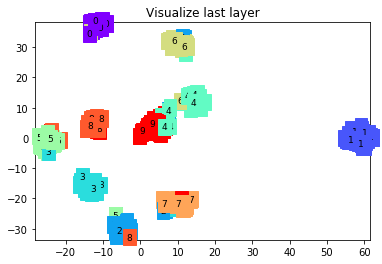

Train-Acc@3: 0.95305
Test-Acc@3: 0.9561


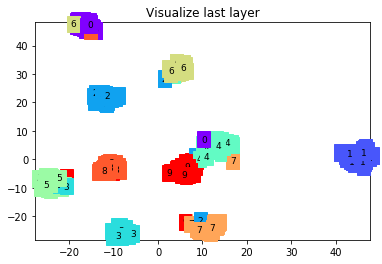

Train-Acc@4: 0.9587166666666667
Test-Acc@4: 0.9654


In [8]:
train_accs = []
test_accs = []

for epoch_i in range(n_epoch):
    correct = 0

    for x, y in train_loader:
        x = x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)
        x, y = x.to(device), y.to(device)
        
        logit, _ = classifier(x)
        loss = loss_func(logit, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = classifier.classify_from_logit(logit)
        correct += (y_pred == y).sum().item()

    train_accs.append(correct / len(train_data))

    with torch.no_grad():
        correct = 0

        for _index, (x, y) in enumerate(test_loader):
            x = x.view(-1, 28, 28)
            x, y = x.to(device), y.to(device)

            y_pred, last_layer = classifier.classify(x)
            correct += (y_pred == y).sum().item()

            if HAS_SK and _index == 0:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.cpu().data.numpy()[:plot_only, :])
                labels = y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)

        test_accs.append(correct / len(test_data))
        
    print("Train-Acc@{}: {}".format(epoch_i, train_accs[-1]))
    print("Test-Acc@{}: {}".format(epoch_i, test_accs[-1]))

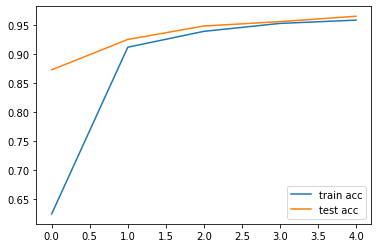

In [9]:
plt.plot(train_accs, label='train acc')
plt.plot(test_accs, label='test acc')
plt.legend()